In [48]:
#Plot of confirmed Corona cases in selected countries.
#Last update: 2020-03-11, JL

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#https://github.com/CSSEGISandData/COVID-19
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

In [2]:
df = pd.read_csv(url,index_col=None)
df=df.drop(['Lat','Long'],axis=1)
df=df.set_index([*df.columns[:2]])
df=df.stack().reset_index()
df.columns=['state','country','date','cases']
df.date=pd.to_datetime(df.date)
df.head()

,state,country,date,cases
0,Anhui,Mainland China,2020-01-22,1
1,Anhui,Mainland China,2020-01-23,9
2,Anhui,Mainland China,2020-01-24,15
3,Anhui,Mainland China,2020-01-25,39
4,Anhui,Mainland China,2020-01-26,60


In [41]:
allCountries=sorted(df.country.unique())
for a,b,c in zip(allCountries[::3],allCountries[1::3],allCountries[2::3]):
    print('{:<30}{:<30}{:<}'.format(a,b,c))

Afghanistan                   Albania                       Algeria
Andorra                       Argentina                     Armenia
Australia                     Austria                       Azerbaijan
Bahrain                       Bangladesh                    Belarus
Belgium                       Bhutan                        Bosnia and Herzegovina
Brazil                        Brunei                        Bulgaria
Burkina Faso                  Cambodia                      Cameroon
Canada                        Channel Islands               Chile
Colombia                      Costa Rica                    Croatia
Cyprus                        Czech Republic                Denmark
Dominican Republic            Ecuador                       Egypt
Estonia                       Faroe Islands                 Finland
France                        French Guiana                 Georgia
Germany                       Gibraltar                     Greece
Holy See                      Hon

In [42]:
plotCountries=['Germany','Italy','France','Spain','Iran (Islamic Republic of)','South Korea','Japan','Portugal']
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')

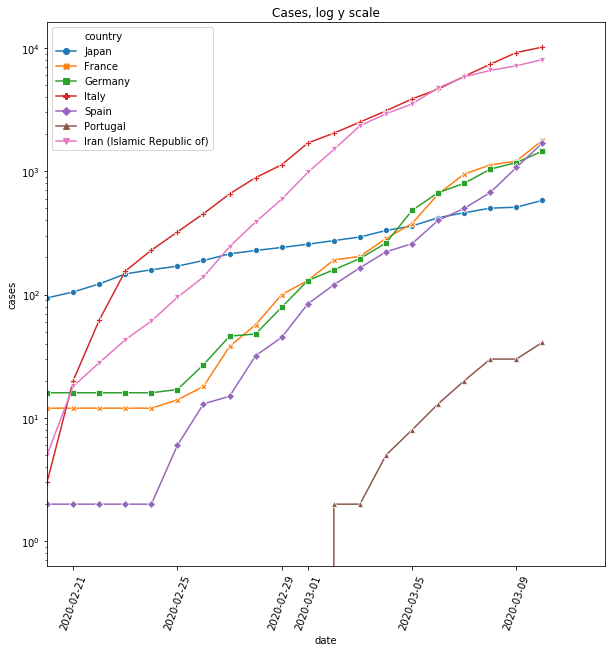

In [43]:
plt.subplots(figsize=(10,10))
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)
ax = g.axes
ax.set_yscale('log')
plt.title('Cases, log y scale')
plt.xlim(left=plotStartDate)
plt.xticks(rotation=70);

In [44]:
df.date.max()

Timestamp('2020-03-10 00:00:00')

Note similar slopes of european countries. Italy took of earlier

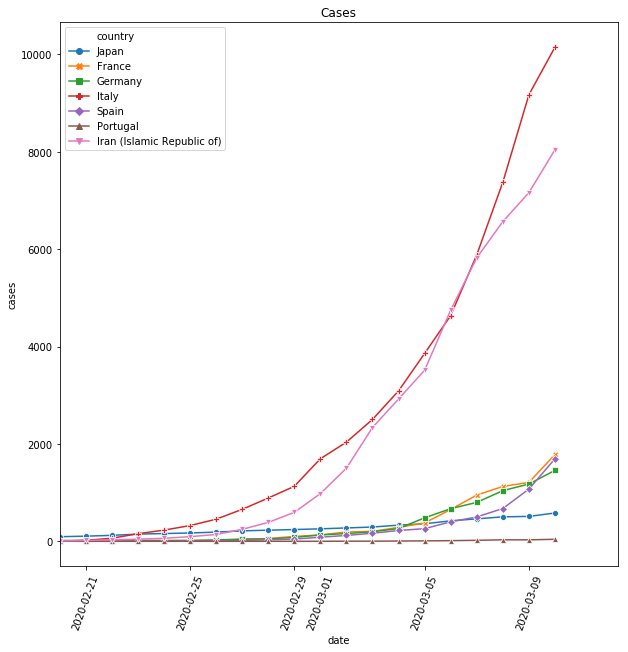

In [46]:
plt.subplots(figsize=(10,10))
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.title('Cases');
plt.xticks(rotation=70);
plt.xlim(left=plotStartDate);

In [47]:
ix=df.country.isin([plotCountries[0]])
df.loc[ix][-3:]

,state,country,date,cases
2300,NaN,Germany,2020-03-08,1040
2301,NaN,Germany,2020-03-09,1176
2302,NaN,Germany,2020-03-10,1457
